**Objective**

The primary objective of this analysis is to examine a dataset simulating Fetal Heart Rate (FHR) and Uterine Contractions (UC) during non-stress tests (NST). The analysis involves visualizing the data, performing FHR calculations in defined epochs, detecting peaks in UC, and providing insights based on these observations.

**Dataset Overview**

**The dataset contains the following fields:**

1. **Time (ms):** The time in milliseconds since the start of the recording, with data points recorded at 250 ms intervals.
2. **FHR (BPM):** Fetal heart rate, measured in beats per minute.
3. **UC (TOCO):** Uterine contractions represented by numeric values indicating their strength and occurrence.

In [63]:
#Import Required Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
data=pd.read_csv(r'E:\Simulator_readings.csv')    #Load Dataset

In [4]:
data.sample(8) # for displaying random 8 row

,Time(ms),Fhr1(BPM),Fhr2(BPM),Uc(TOCO)
2097,524500,128,0,17
165,41500,141,0,70
840,210250,146,0,11
845,211500,147,0,11
1774,443750,126,0,11
1685,421500,137,0,11
71,18000,126,0,26
968,242250,156,0,11


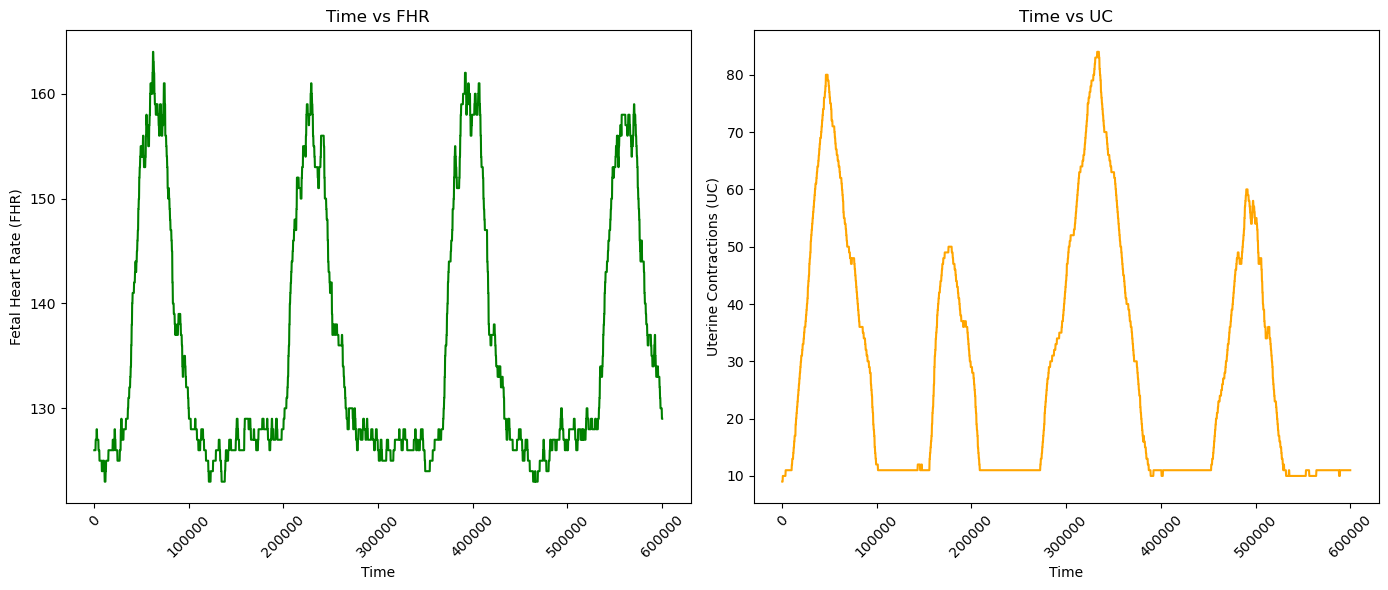

In [19]:
# Plotting
plt.figure(figsize=(14, 6))

# Subplot for FHR
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
sns.lineplot(x='Time(ms)', y='Fhr1(BPM)', data=data, color='green')
plt.title('Time vs FHR')
plt.xlabel('Time')
plt.ylabel('Fetal Heart Rate (FHR)')
plt.xticks(rotation=45)

# Subplot for UC
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
sns.lineplot(x='Time(ms)', y='Uc(TOCO)', data=data, color='orange')
plt.title('Time vs UC')
plt.xlabel('Time')
plt.ylabel('Uterine Contractions (UC)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Time(ms)   2400 non-null   int64
 1   Fhr1(BPM)  2400 non-null   int64
 2   Fhr2(BPM)  2400 non-null   int64
 3   Uc(TOCO)   2400 non-null   int64
dtypes: int64(4)
memory usage: 75.1 KB


In [10]:
data.columns

Index(['Time(ms)', 'Fhr1(BPM)', 'Fhr2(BPM)', 'Uc(TOCO)'], dtype='object')

In [14]:
del data['Fhr2(BPM)'] # delete unnecessary column

In [15]:
data.head()

,Time(ms),Fhr1(BPM),Uc(TOCO)
0,250,126,9
1,500,126,9
2,750,126,10
3,1000,126,10
4,1250,126,10


In [45]:
# Convert the 'Time(ms)' column to datetime format if it's in milliseconds
data['Time(ms)'] = pd.to_datetime(data['Time(ms)'], unit='250')

In [46]:
# Ensure data is sorted by time
data = data.sort_values('Time(ms)')

In [47]:
data.head()

,Time(ms),Fhr1(BPM),Uc(TOCO)
0,1970-01-01 00:00:00.250,126,9
1,1970-01-01 00:00:00.500,126,9
2,1970-01-01 00:00:00.750,126,10
3,1970-01-01 00:00:01.000,126,10
4,1970-01-01 00:00:01.250,126,10


In [48]:
# Set the epoch duration (3.75 seconds)
epoch_duration = '3.75S'

In [49]:
# Resample the data into 3.75-second epochs and calculate the mean FHR
resampled_data = data.resample(epoch_duration, on='Time(ms)').mean()

In [50]:
resampled_data.head()

,Fhr1(BPM),Uc(TOCO)
Time(ms),,
1970-01-01 00:00:00.000,126.714286,9.857143
1970-01-01 00:00:03.750,125.800000,11.000000
1970-01-01 00:00:07.500,124.600000,11.400000
1970-01-01 00:00:11.250,124.333333,16.133333
1970-01-01 00:00:15.000,125.933333,23.733333


In [51]:
# Calculate the pulse interval in milliseconds
resampled_data['Pulse Interval (ms)'] = 60000 / resampled_data['Fhr1(BPM)']

In [52]:
# Drop rows where 'Fhr1(BPM)' is NaN
resampled_data = resampled_data.dropna(subset=['Fhr1(BPM)'])

In [53]:
# Reset the index to have 'Epoch Start' as a column
resampled_data = resampled_data.reset_index()

In [54]:
# Rename columns for clarity
resampled_data = resampled_data.rename(columns={'Time(ms)': 'Epoch Start', 'Fhr1(BPM)': 'Avg FHR (bpm)'})

In [55]:
resampled_data.head()

,Epoch Start,Avg FHR (bpm),Uc(TOCO),Pulse Interval (ms)
0,1970-01-01 00:00:00.000,126.714286,9.857143,473.506201
1,1970-01-01 00:00:03.750,125.800000,11.000000,476.947536
2,1970-01-01 00:00:07.500,124.600000,11.400000,481.540931
3,1970-01-01 00:00:11.250,124.333333,16.133333,482.573727
4,1970-01-01 00:00:15.000,125.933333,23.733333,476.442562


In [56]:
# Extract the UC data (assuming the UC data is in a column named 'UC')
uc_data = data['Uc(TOCO)'].values

In [57]:
print(uc_data)

[ 9  9 10 ... 11 11 11]


In [58]:
from scipy.signal import find_peaks, peak_widths
# Perform peak detection
peaks, _ = find_peaks(uc_data)

In [59]:
# Calculate the width of each peak at half its maximum height
widths, width_heights, left_ips, right_ips = peak_widths(uc_data, peaks, rel_height=0.5)

# Convert widths from sample points to time (assuming the data is sampled at 1 Hz)
widths_in_seconds = widths

# Count peaks where the width is more than 30 seconds
counted_peaks = widths_in_seconds[widths_in_seconds > 30]

# Calculate the average duration of the counted UC peaks
average_duration = np.mean(counted_peaks)

In [60]:
# Report the results
print(f"Number of peaks with width > 30 seconds: {len(counted_peaks)}")
print(f"Average duration of counted UC peaks: {average_duration:.2f} seconds")

Number of peaks with width > 30 seconds: 6
Average duration of counted UC peaks: 142.58 seconds


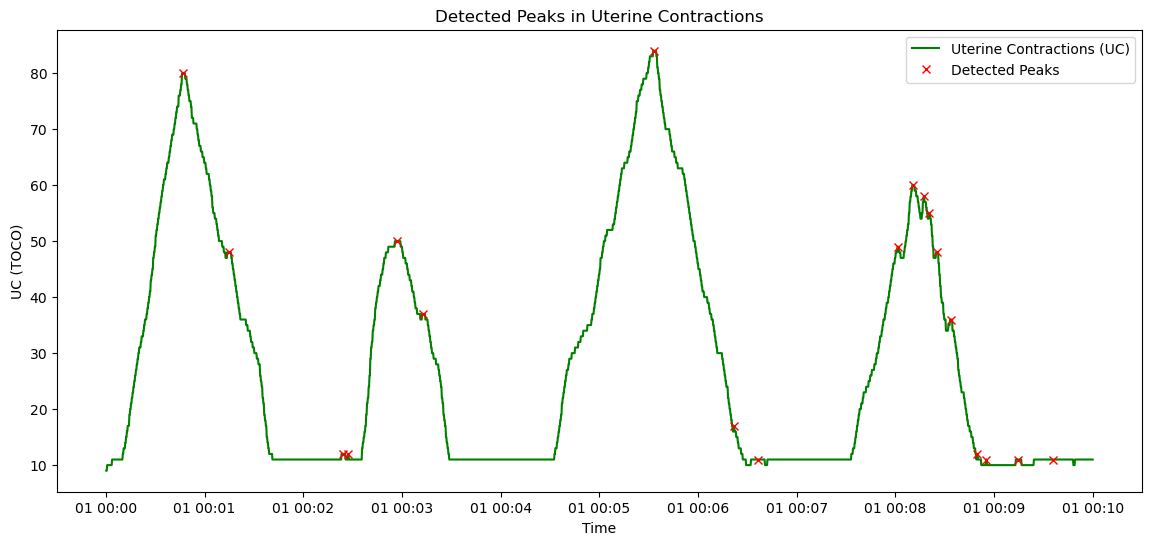

In [61]:
# Optional: Plot peaks on the UC graph for visualization
plt.figure(figsize=(14, 6))
plt.plot(data['Time(ms)'], data['Uc(TOCO)'], label='Uterine Contractions (UC)', color='green')
plt.plot(data['Time(ms)'].iloc[peaks], data['Uc(TOCO)'].iloc[peaks], "x", color='Red', label='Detected Peaks')
plt.title('Detected Peaks in Uterine Contractions')
plt.xlabel('Time')
plt.ylabel('UC (TOCO)')
plt.legend()
plt.show()

* Load and inspect the dataset.
* Visualize FHR and UC data over time using dual-axis plots.
* Analyze FHR by dividing data into epochs and calculating averages.
* Perform UC peak detection and analyze peak widths.